# HR Analytics: Job Change of Data Scientists

# Xgboost Model Performance

| Model              | Accuracy (testing set) | AUC score (testing set) |
| :--                | :--                    |:--                      |
| **Default**        | 0.859                  | 0.935                   |
| **Final Model**    | 0.862                  | 0.937                   |


**Footnote**
- Default model: The model using default hyper parameters.
- Final model: The model with tuned hyper parameters.

# Let's start the  hyper parameter optimization 

## Modules

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [2]:
import os # Set the working directory
print (os.getcwd())

C:\Users\15177\Python_Project\HR_Analysis


In [3]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import  metrics

In [4]:
#### Save grid search object
# https://stackoverflow.com/questions/51424312/how-to-save-gridsearchcv-object
import joblib

# Load the processed dataset

In [5]:
import os
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
from numpy import genfromtxt
X_train_scaled = genfromtxt('X_train_scaled.csv', delimiter=',')
X_test_scaled = genfromtxt('X_test_scaled.csv', delimiter=',')
y_train = genfromtxt('y_train.csv', delimiter=',')
y_test = genfromtxt('y_test.csv', delimiter=',')

In [6]:
# feature name for the transformed X
feature_name = pd.read_csv('X_index.csv')['feature_name']
feature_name

0      city_development_index
1              training_hours
2                   x0_city_1
3                  x0_city_10
4                 x0_city_100
                ...          
148                x5_Pvt Ltd
149           education_level
150                experience
151              company_size
152              last_new_job
Name: feature_name, Length: 153, dtype: object

In [7]:
# creat dictionary to show better-annotated feature index
my_key = ['f'+str(x) for x in range(0,154)]
my_value = list(feature_name)
my_f_dict = dict(zip(my_key, my_value))
my_f_dict

{'f0': 'city_development_index',
 'f1': 'training_hours',
 'f2': 'x0_city_1',
 'f3': 'x0_city_10',
 'f4': 'x0_city_100',
 'f5': 'x0_city_101',
 'f6': 'x0_city_102',
 'f7': 'x0_city_103',
 'f8': 'x0_city_104',
 'f9': 'x0_city_105',
 'f10': 'x0_city_106',
 'f11': 'x0_city_107',
 'f12': 'x0_city_109',
 'f13': 'x0_city_11',
 'f14': 'x0_city_111',
 'f15': 'x0_city_114',
 'f16': 'x0_city_115',
 'f17': 'x0_city_116',
 'f18': 'x0_city_117',
 'f19': 'x0_city_118',
 'f20': 'x0_city_12',
 'f21': 'x0_city_120',
 'f22': 'x0_city_121',
 'f23': 'x0_city_123',
 'f24': 'x0_city_126',
 'f25': 'x0_city_127',
 'f26': 'x0_city_128',
 'f27': 'x0_city_129',
 'f28': 'x0_city_13',
 'f29': 'x0_city_131',
 'f30': 'x0_city_133',
 'f31': 'x0_city_134',
 'f32': 'x0_city_136',
 'f33': 'x0_city_138',
 'f34': 'x0_city_139',
 'f35': 'x0_city_14',
 'f36': 'x0_city_140',
 'f37': 'x0_city_141',
 'f38': 'x0_city_142',
 'f39': 'x0_city_143',
 'f40': 'x0_city_144',
 'f41': 'x0_city_145',
 'f42': 'x0_city_146',
 'f43': 'x0_ci

# Create a function to find the optimal parameter according to grid search

In [8]:
def fnc_show_best_param(grid_search):
    gsearch = grid_search
    params = np.array( [x for x in gsearch.cv_results_['params']] )
    test_cv_score = gsearch.cv_results_['mean_test_score']
    my_dict= {'params':params,'test_cv_score': test_cv_score}
    df = pd.DataFrame(my_dict).sort_values(by='test_cv_score',ascending=False)
    print(df)

# Create a function to find the optimal number of trees using xgb.cv

In [9]:
# test_results = pd.read_csv('test_results.csv')
# This file is not avaiable

def modelfit(alg, Xtrain, ytrain, Xtest, ytest, 
             feature_name = feature_name,
             cv_folds=5, 
             my_f_dict = my_f_dict, 
             early_stopping_rounds=50):
    
    #### Train Set ####
        
    # Get the parameter from the input model(alg)
    xgb_param = alg.get_xgb_params()

    #### Prepare train data for xgboost ####
    # Note:
    # DMatrix is an internal data structure that is used by XGBoost, 
    # which is optimized for both memory efficiency and training speed. 
    # You can construct DMatrix from multiple different sources of data.
    xgtrain = xgb.DMatrix(Xtrain, label= ytrain)

    #### Run CV to determine the optimal number of tress ####
    # Note: https://rdrr.io/cran/xgboost/man/xgb.cv.html ####
    cvresult = xgb.cv(params= xgb_param, 
                      dtrain= xgtrain, # Data to be trained.
                      num_boost_round=alg.get_params()['n_estimators'], 
                      nfold=cv_folds,
                      metrics='auc', 
                      early_stopping_rounds=early_stopping_rounds)

    #### Report the optimal tree numbers ####
    print('optimal number of trees')
    print(cvresult.shape[0])

    #### Update tree numbers using the optimal number of trees ####
    alg.set_params(n_estimators=cvresult.shape[0])
        
    
    #### Fit data to the 'updated' model ####
    alg.fit(Xtrain, ytrain, eval_metric='auc')
        
    #### Predict y using training set and the updated model ####
    train_y_pred      = alg.predict(Xtrain)
    train_y_predprob  = alg.predict_proba(Xtrain)[:,1]
    print ("\nModel Report - The number of trees is updated already based on xgb.cv and training set")
    print ("Accuracy (Train) : %.4g" % metrics.accuracy_score(ytrain , train_y_pred)     )
    print ("AUC Score (Train): %f"   % metrics.roc_auc_score( ytrain , train_y_predprob) )

    #### The following code is not applicable
    test_y_pred     = alg.predict(      Xtest)
    test_y_predprob = alg.predict_proba(Xtest)[:,1]
    print ("\n")
    print ("Accuracy (Test) : %.4g" % metrics.accuracy_score(ytest, test_y_pred) )
    print ('AUC Score (Test): %f'    % metrics.roc_auc_score( ytest, test_y_predprob) )
    
    
    #### Features importance ####
    f_imp_value = list(alg.get_booster().get_fscore().values())
    f_index_transformed = list(alg.get_booster().get_fscore().keys())
    f_index_bettername =[my_f_dict[x] for x in f_index_transformed]
    feat_imp = pd.Series(data= f_imp_value, index = f_index_bettername ).sort_values(ascending=False)
        
    # Select features with higher importance
    # feat_imp_filter = feat_imp[feat_imp> 50]
    feat_imp_filter = feat_imp[0:15]
    feat_imp_filter.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score (Train)')
    
    
    #### output 
    return(alg)

optimal number of trees
231

Model Report - The number of trees is updated already based on xgb.cv and training set
Accuracy (Train) : 0.8845
AUC Score (Train): 0.953684


Accuracy (Test) : 0.8596
AUC Score (Test): 0.934917


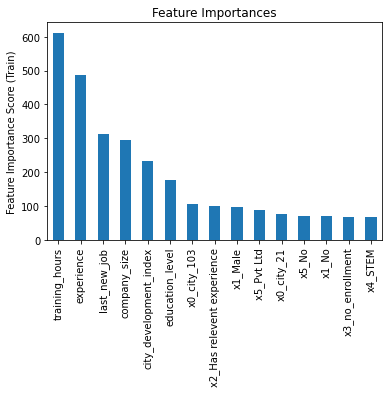

In [10]:
#### Function testing
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic', # Learning Task Parameters-> https://xgboost.readthedocs.io/en/latest/parameter.html
        scale_pos_weight=1,
        seed=27,
        use_label_encoder=False)

trained_model = modelfit(xgb1, X_train_scaled, y_train, X_test_scaled, y_test)

# Tune for Model

## Step 1- Find the number of estimators for a high learning rate

Why? Using a higher learning rate with optimal number of trees we can reduce the time in parameter tuning. After all other parameters are tuned, we can reduce the learning rate (and increase the trees/estimators) to increase the model's performance. 

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

**max_depth** = 5 : This should be between 3-10. 4-6 can be good starting points. I used 5 as initial value, we will tune this later.  

**min_child_weight** = 1 : THis parameter means something like “stop trying to split once you reach a certain degree of purity in a node and your model can fit it”. Thus, higher value can prevent overfitting. The Default value is 1, but a smaller value should be chosen if it is a highly imbalanced class problem.

**gamma** = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later. 

**subsample, colsample_bytree** = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9. 

**scale_pos_weight** = 1: Because of high class imbalance. Please note that all the above are just initial estimates and will be tuned later. 

Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. 

The function defined above will do it for us.

optimal number of trees
231

Model Report - The number of trees is updated already based on xgb.cv and training set
Accuracy (Train) : 0.8845
AUC Score (Train): 0.953684


Accuracy (Test) : 0.8596
AUC Score (Test): 0.934917


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=231, n_jobs=8, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

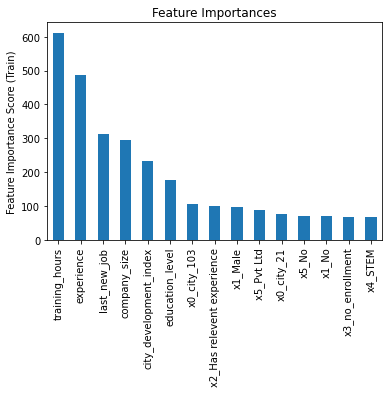

In [11]:
#### Set up the model ####
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        scale_pos_weight=1,
        seed=27,
        use_label_encoder=False)

#### use the xgb.cv to find the optimal number of trees for the initial xgb model
modelfit(xgb1, X_train_scaled, y_train, X_test_scaled, y_test)

optimal number of trees is 262. Let's update the parameter and go into the step-2


## Step 2: Tune max_depth and min_child_weight

Tune max_depth and min_child_weight will have the highest impact on model outcome. Thus, we tune them first. 

The strategy is to do **coarse search** with wider ranges and then **fine search** with smaller ranges.

In [12]:
param_test= {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}


#### Set up the xgb model ####
xgb2 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=262,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       max_depth=5,
                       min_child_weight=1, 
                       gamma=0, 
                       subsample=0.8, 
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)

#### Set up the grid search ####
gsearch_2_1 = GridSearchCV(estimator = xgb2, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_2_1.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_2_1, 'xbg_grid_search_2_1.pkl')

[01:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['grid_search_2_1.pkl']

In [13]:
#### Read grid search results ####
gsearch_2_1 = joblib.load("xbg_grid_search_2_1.pkl")
fnc_show_best_param(gsearch_2_1)

                                     params  test_cv_score
4   {'max_depth': 5, 'min_child_weight': 3}       0.933126
3   {'max_depth': 5, 'min_child_weight': 1}       0.932868
5   {'max_depth': 5, 'min_child_weight': 5}       0.932515
1   {'max_depth': 3, 'min_child_weight': 3}       0.932089
2   {'max_depth': 3, 'min_child_weight': 5}       0.932046
0   {'max_depth': 3, 'min_child_weight': 1}       0.932032
6   {'max_depth': 7, 'min_child_weight': 1}       0.931910
8   {'max_depth': 7, 'min_child_weight': 5}       0.931469
7   {'max_depth': 7, 'min_child_weight': 3}       0.931330
9   {'max_depth': 9, 'min_child_weight': 1}       0.930262
10  {'max_depth': 9, 'min_child_weight': 3}       0.930107
11  {'max_depth': 9, 'min_child_weight': 5}       0.929903


1. Here, we have run 12 combinations with wider intervals between values. The ideal values are 5 for max_depth and 1 for min_child_weight. 

2. Lets go one step deeper and look for optimum values.

In [14]:
param_test= {
    'max_depth':[4,5,6],
    'min_child_weight':[0, 0.1, 0.5, 1]
}


#### Set up the xgb model ####
xgb2 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=262,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       max_depth=5,
                       min_child_weight=1, 
                       gamma=0, 
                       subsample=0.8, 
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_2_2 = GridSearchCV(estimator = xgb2, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_2_2.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_2_2, 'xbg_grid_search_2_2.pkl')

[02:05:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['grid_search_2_2.pkl']

In [15]:
gsearch_2_2 = joblib.load("xbg_grid_search_2_2.pkl")
fnc_show_best_param(gsearch_2_2)

                                       params  test_cv_score
7     {'max_depth': 5, 'min_child_weight': 1}       0.932868
5   {'max_depth': 5, 'min_child_weight': 0.1}       0.932795
4     {'max_depth': 5, 'min_child_weight': 0}       0.932790
1   {'max_depth': 4, 'min_child_weight': 0.1}       0.932733
8     {'max_depth': 6, 'min_child_weight': 0}       0.932639
10  {'max_depth': 6, 'min_child_weight': 0.5}       0.932561
6   {'max_depth': 5, 'min_child_weight': 0.5}       0.932552
0     {'max_depth': 4, 'min_child_weight': 0}       0.932550
3     {'max_depth': 4, 'min_child_weight': 1}       0.932522
2   {'max_depth': 4, 'min_child_weight': 0.5}       0.932518
11    {'max_depth': 6, 'min_child_weight': 1}       0.932439
9   {'max_depth': 6, 'min_child_weight': 0.1}       0.932369


In [16]:
param_test= {
    'max_depth':[5,6,7],
    'min_child_weight':[0.45, 0.5, 0.55]
}


#### Set up the xgb model ####
xgb2 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=262,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       max_depth=5,
                       min_child_weight=1, 
                       gamma=0, 
                       subsample=0.8, 
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_2_3 = GridSearchCV(estimator = xgb2, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_2_3.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_2_3, 'xbg_grid_search_2_3.pkl')

[02:11:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['grid_search_2_3.pkl']

In [17]:
gsearch_2_3 = joblib.load("xbg_grid_search_2_3.pkl")
fnc_show_best_param(gsearch_2_3)

                                       params  test_cv_score
0  {'max_depth': 5, 'min_child_weight': 0.45}       0.932986
2  {'max_depth': 5, 'min_child_weight': 0.55}       0.932673
5  {'max_depth': 6, 'min_child_weight': 0.55}       0.932601
4   {'max_depth': 6, 'min_child_weight': 0.5}       0.932561
1   {'max_depth': 5, 'min_child_weight': 0.5}       0.932552
3  {'max_depth': 6, 'min_child_weight': 0.45}       0.932427
6  {'max_depth': 7, 'min_child_weight': 0.45}       0.931504
7   {'max_depth': 7, 'min_child_weight': 0.5}       0.931412
8  {'max_depth': 7, 'min_child_weight': 0.55}       0.931069


Best  parameter {'max_depth': 6, 'min_child_weight': 0.5}      

## Step 3: Tune gamma
Only when the resulting split leads to a positive reduction in the loss function, then a node will be split. Higher gamma makes the algorithm more conservative (less specific to the particular sample). Thus, we can use gamma to avoid over-fitting.

According to the discussion *https://stats.stackexchange.com/questions/418687/gamma-parameter-in-xgboost* , gamma is more importnat when we have a shallow (low max_depth) trees.


**Plan to do**
Update the tuned parameters. Then, I select a range around 0-1 as initial grid search for gamma.

In [18]:
np.arange(0, 1.1, 0.2) 

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [19]:
param_test= {
    'gamma': np.arange(0, 1.1, 0.2) 
}


#### Set up the xgb model ####
xgb3 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=262,
                       max_depth= 6,
                       min_child_weight= 0.5,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       gamma=0, 
                       subsample=0.8, 
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_3_1 = GridSearchCV(estimator = xgb3, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_3_1.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_3_1, 'xbg_grid_search_3_1.pkl')

[02:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['grid_search_3_1.pkl']

In [20]:
grid_search_3_1 = joblib.load("xbg_grid_search_3_1.pkl")
fnc_show_best_param(grid_search_3_1)

                          params  test_cv_score
2                 {'gamma': 0.4}       0.932631
5                 {'gamma': 1.0}       0.932611
0                 {'gamma': 0.0}       0.932561
4                 {'gamma': 0.8}       0.932505
3  {'gamma': 0.6000000000000001}       0.932450
1                 {'gamma': 0.2}       0.932378


In [21]:
np.arange(0.1, 0.3, 0.05) 

array([0.1 , 0.15, 0.2 , 0.25])

In [22]:
param_test= {
    'gamma':[0.15, 0.2 , 0.25]
}


#### Set up the xgb model ####
xgb3 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=262,
                       max_depth= 6,
                       min_child_weight= 0.5,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       subsample=0.8, 
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_3_2 = GridSearchCV(estimator = xgb3, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_3_2.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_3_2, 'xbg_grid_search_3_2.pkl')


#### Show the best parameters
grid_search_3_2 = joblib.load("xbg_grid_search_3_2.pkl")
fnc_show_best_param(grid_search_3_2)

[02:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
            params  test_cv_score
0  {'gamma': 0.15}       0.932739
1   {'gamma': 0.2}       0.932378
2  {'gamma': 0.25}       0.932349


 Great! 0.2 is best for gamma.

### Before proceeding, it's good to re-calibrate the number of trees based on the newly-updated parameters.

optimal number of trees
231

Model Report - The number of trees is updated already based on xgb.cv and training set
Accuracy (Train) : 0.8942
AUC Score (Train): 0.963544


Accuracy (Test) : 0.8608
AUC Score (Test): 0.936201


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=231, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

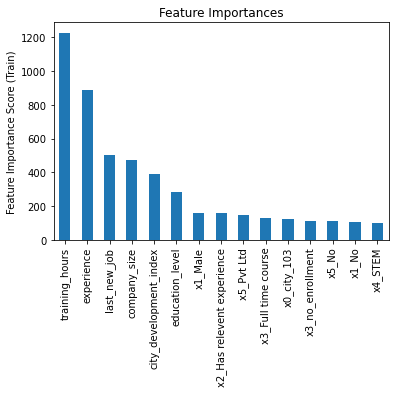

In [23]:
#### Set up the model ####
xgb4 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=2000, # Rest the n_estimators to be a large number
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       subsample=0.8, 
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)

#### use the xgb.cv to find the optimal number of trees for the initial xgb model
modelfit(xgb4, X_train_scaled, y_train, X_test_scaled, y_test)
#### Note: This function will return the optimal number of the trees.

# Step 4: Tune subsample and colsample_bytree

**subsample** Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur for each boosting iteration.


**colsample_bytree** is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed

**Plan to do**
The next step would be try different **subsample** and **colsample_bytree values**. 
Lets do coarse and then fine grid search.

In [24]:
np.arange(0.6,1.0,0.1)

array([0.6, 0.7, 0.8, 0.9])

In [25]:
param_test= {
    'subsample':np.arange(0.6,1.0,0.1),
    'colsample_bytree':np.arange(0.6,1.0,0.1)
}


#### Set up the xgb model ####
xgb4 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=185, # This is updated
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_4_1 = GridSearchCV(estimator = xgb4, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_4_1.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_4_1, 'xbg_grid_search_4_1.pkl')


#### Show the best parameters
grid_search_4_1 = joblib.load("xbg_grid_search_4_1.pkl")
fnc_show_best_param(grid_search_4_1)

[02:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                                               params  test_cv_score
15  {'colsample_bytree': 0.8999999999999999, 'subs...       0.933582
14  {'colsample_bytree': 0.8999999999999999, 'subs...       0.933397
6   {'colsample_bytree': 0.7, 'subsample': 0.79999...       0.933305
11  {'colsample_bytree': 0.7999999999999999, 'subs...       0.933208
10  {'colsample_bytree': 0.7999999999999999, 'subs...       0.932971
8   {'colsample_bytree': 0.7999999999999999, 'subs...       0.932917
3   {'colsample_bytree': 0.6, 'subsample': 0.89999...       0.932874
1         {'colsample_bytree': 0.6, 'subsample': 0.7}       0.932815
7   {'colsample_bytree': 0.7, 'subsample': 0.89999...       0.932808


In [26]:
[i/100 for i in range(50,65,5)]

[0.5, 0.55, 0.6]

In [27]:
param_test= {
    'subsample':[i/100 for i in range(50,65,5)],
    'colsample_bytree':[i/100 for i in range(50,65,5)]
}


#### Set up the xgb model ####
xgb4 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=185, # This is updated
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_4_2 = GridSearchCV(estimator = xgb4, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_4_2.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_4_2, 'xbg_grid_search_4_2.pkl')


#### Show the best parameters
grid_search_4_2 = joblib.load("xbg_grid_search_4_2.pkl")
fnc_show_best_param(grid_search_4_2)

[02:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                                          params  test_cv_score
2    {'colsample_bytree': 0.5, 'subsample': 0.6}       0.932667
5   {'colsample_bytree': 0.55, 'subsample': 0.6}       0.932666
1   {'colsample_bytree': 0.5, 'subsample': 0.55}       0.932632
4  {'colsample_bytree': 0.55, 'subsample': 0.55}       0.932606
3   {'colsample_bytree': 0.55, 'subsample': 0.5}       0.932509
8    {'colsample_bytree': 0.6, 'subsample': 0.6}       0.932423
6    {'colsample_bytree': 0.6, 'subsample': 0.5}       0.932380
0    {'colsample_bytree': 0.5, 'subsample': 0.5}       0.932360
7   {'colsample_bytree': 0.6, 'subsample': 0.55}       0.932023


{'colsample_bytree': 0.6, 'subsample': 0.6}  is the best

# Step 5: Tuning Regularization Parameters
Next step is to tune regularization. Another parameter to avoid overfitting. 

I will tune **reg_lambda**: L2 regularization term on weights. The default is 1. Increasing this value will make model more conservative.

The other regularization is L1 which can be used for feature selection, so I won't tune it, because the goal of this model is to make prediction. 

In [28]:
#### coarse grid search ####
param_test = {
    'reg_alpha':[1e-5, 1e-2, 1e-1, 1, 10]
}


#### Set up the xgb model ####
xgb5 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=185, # This is updated
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
                       colsample_bytree=0.6,
                       subsample=0.6,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_5_1 = GridSearchCV(estimator = xgb5, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_5_1.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_5_1, 'xbg_gsearch_5_1.pkl')


#### Show the best parameters
grid_search_5_1 = joblib.load("xbg_gsearch_5_1.pkl")
fnc_show_best_param(grid_search_5_1)

[02:33:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                 params  test_cv_score
2    {'reg_alpha': 0.1}       0.932901
1   {'reg_alpha': 0.01}       0.932454
3      {'reg_alpha': 1}       0.932444
0  {'reg_alpha': 1e-05}       0.932423
4     {'reg_alpha': 10}       0.931882


In [29]:
### fine grid search ####
param_test = {
    'reg_alpha':[1e-11, 1e-8, 1e-6, 1e-5, 1e-4]
}


#### Set up the xgb model ####
xgb5 = XGBClassifier(
                       # Tuned parameters
                       n_estimators=185, # This is updated
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
                       colsample_bytree=0.6,
                       subsample=0.6,
    
                       # Non-tuned parameters
                       learning_rate =0.1, 
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)


#### Set up the grid search ####
gsearch_5_2 = GridSearchCV(estimator = xgb5, 
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

#### Run grid search ####
gsearch_5_2.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_5_2, 'xbg_gsearch_5_2.pkl')


#### Show the best parameters
grid_search_5_2 = joblib.load("xbg_gsearch_5_2.pkl")
fnc_show_best_param(grid_search_5_2)

[02:35:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                  params  test_cv_score
4  {'reg_alpha': 0.0001}       0.932423
3   {'reg_alpha': 1e-05}       0.932423
0   {'reg_alpha': 1e-11}       0.932423
1   {'reg_alpha': 1e-08}       0.932423
2   {'reg_alpha': 1e-06}       0.932423


 We can keep searching the best parameters aroung 0.0001, but we may not get any impressive gain. Thus, I will stop here and use  {'reg_alpha': 0.0001} as optimal value. 

# Step 6: Reducing Learning Rate

This is the final stage of tuing parameters. We will reduce learning rate and increase the number of trees. 

This process greatly rely on the xgt.cv function of XGBoost to select the optimal number of trees.

optimal number of trees
138

Model Report - The number of trees is updated already based on xgb.cv and training set
Accuracy (Train) : 0.8845
AUC Score (Train): 0.953730


Accuracy (Test) : 0.859
AUC Score (Test): 0.934919


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=138, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

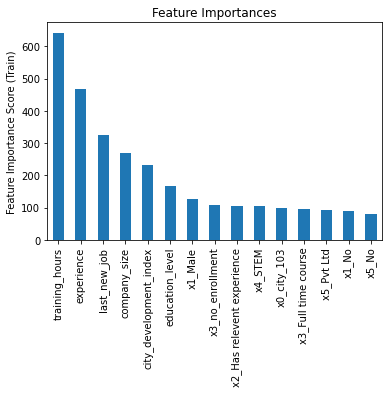

In [30]:
xgb6_0 = XGBClassifier(
                       # Learning rate and number of tree
                       learning_rate =0.1, 
                       n_estimators=5000, # This is updated
                       
                       # Tuned parameters
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
                       colsample_bytree=0.6,
                       subsample=0.6,
                       reg_alpha= 0.0001,
    
                       # Non-tuned parameters
                
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)

#### use the xgb.cv to find the optimal number of trees for the initial xgb model
modelfit(xgb6_0, X_train_scaled, y_train, X_test_scaled, y_test)
#### Note: This function will return the optimal number of the trees.

optimal number of trees
260

Model Report - The number of trees is updated already based on xgb.cv and training set
Accuracy (Train) : 0.889
AUC Score (Train): 0.958172


Accuracy (Test) : 0.8622
AUC Score (Test): 0.936449


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=6,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=260, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

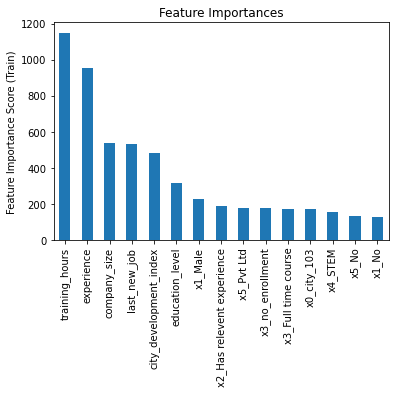

In [31]:
xgb6_1 = XGBClassifier(
                       # Learning rate and number of tree
                       learning_rate =0.07, 
                       n_estimators=5000, 
                       
                       # Tuned parameters
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
                       colsample_bytree=0.6,
                       subsample=0.6,
                       reg_alpha= 0.0001,
    
                       # Non-tuned parameters
                
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)

#### use the xgb.cv to find the optimal number of trees for the initial xgb model
modelfit(xgb6_1, X_train_scaled, y_train, X_test_scaled, y_test)
#### Note: This function will return the optimal number of the trees.

From learning rate 0.1 to 0.07, AUS score (test) get improved and the model has 252 trees.
Let's reduce the learning rate to 0.01

optimal number of trees
1644

Model Report - The number of trees is updated already based on xgb.cv and training set
Accuracy (Train) : 0.8878
AUC Score (Train): 0.957781


Accuracy (Test) : 0.862
AUC Score (Test): 0.936888


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=1644, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

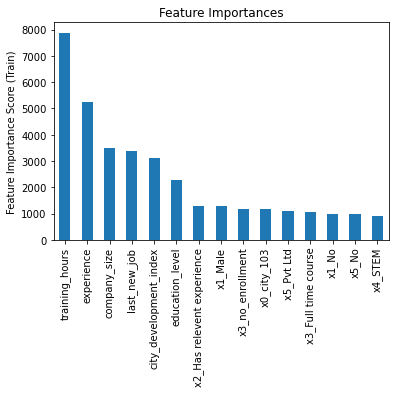

In [32]:
xgb6_2 = XGBClassifier(
                       # Learning rate and number of tree
                       learning_rate =0.01, 
                       n_estimators=10000, 
                       
                       # Tuned parameters
                       max_depth= 6,
                       min_child_weight= 0.5,
                       gamma=0.2,
                       colsample_bytree=0.6,
                       subsample=0.6,
                       reg_alpha= 0.0001,
    
                       # Non-tuned parameters
                
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=1, 
                       seed=27,
                       use_label_encoder=False)

#### use the xgb.cv to find the optimal number of trees for the initial xgb model
modelfit(xgb6_2, X_train_scaled, y_train, X_test_scaled, y_test)
#### Note: This function will return the optimal number of the trees.

From learning rate 0.07 to 0.01, AUS score (test) get improved a bit and the model has 1883 trees. I stop the tuning process at this stage.

# END